In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.1), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [12]:
b = bagreader('/home/msccomputer/catkin_ws/src/out/rosbag/real/vertical_flying/test2/2022-11-11-08-48-11.bag')

b.topic_table

[INFO]  Data folder /home/msccomputer/catkin_ws/src/out/rosbag/real/vertical_flying/test2/2022-11-11-08-48-11 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,2460,30.823472
1,/anafi/gnss_location,sensor_msgs/NavSatFix,2460,30.934639
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,2457,95.893916
3,/anafi/height,olympe_bridge/Float32Stamped,2459,30.806719
4,/anafi/image,sensor_msgs/Image,2460,30.883617
5,/anafi/link_goodput,std_msgs/UInt16,2459,31.154420
6,/anafi/link_quality,std_msgs/UInt8,2459,30.992928
7,/anafi/ned_pose_from_gnss,geometry_msgs/PointStamped,2460,30.885664
8,/anafi/odometry,nav_msgs/Odometry,2459,22.777985
9,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,2459,30.986517


In [13]:
apriltag_pose = b.message_by_topic('/estimate/aprilTags/pose')
df_apriltag_pose = pd.read_csv(apriltag_pose)

df_apriltag_pose

df_apriltag_pose = drop_columns_in_df(df_apriltag_pose)

df_apriltag_pose = df_apriltag_pose[["Time", "x", "y", "z"]]

df_apriltag_pose = rename_columns(df_apriltag_pose, ["apriltag_x", "apriltag_y", "apriltag_z"])

df_apriltag_pose

,Time,apriltag_x,apriltag_y,apriltag_z
0,1.668153e+09,0.008234,-0.011816,0.222442
1,1.668153e+09,-0.000490,-0.011964,0.279868
2,1.668153e+09,-0.016497,-0.008139,0.341102
3,1.668153e+09,-0.016816,-0.002384,0.438788
4,1.668153e+09,0.002672,-0.003025,0.502401
...,...,...,...,...
407,1.668153e+09,0.008211,-0.235643,0.453050
408,1.668153e+09,0.009878,-0.233447,0.416052
409,1.668153e+09,0.015179,-0.235234,0.389655
410,1.668153e+09,0.015712,-0.235069,0.353489


In [14]:
dnn_pose = b.message_by_topic('/estimate/dnn_cv/position')
df_dnn_pose = pd.read_csv(dnn_pose)

df_dnn_pose = drop_columns_in_df(df_dnn_pose)

df_dnn_pose = rename_columns(df_dnn_pose, ["dnn_x", "dnn_y", "dnn_z"])

In [15]:
num_tags = b.message_by_topic('/estimate/aprilTags/num_tags_detected')
df_num_tags = pd.read_csv(num_tags)

df_num_tags = drop_columns_in_df(df_num_tags)

df_num_tags = rename_columns(df_num_tags, ["num_tags"])


In [16]:
#NAN HANDLING AND NP ARRAY GENERATION

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [17]:
df_merged_position = sync_dfs_based_on_time([df_apriltag_pose, df_dnn_pose, df_num_tags])

df_merged_position = normalize_df_time(df_merged_position)

# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
num_tags_data = get_np_arr_without_nan(df_merged_position, ["num_tags"])


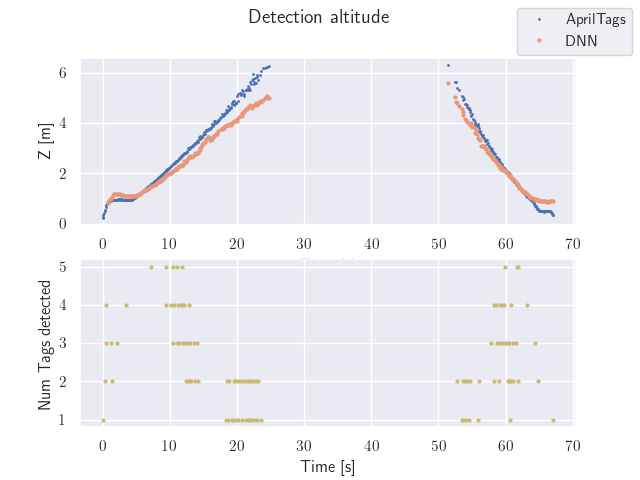

In [18]:
%matplotlib widget

fig, axs = plt.subplots(2, 1)


axs[0].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=1, c='b')
axs[0].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[0].set_ylabel('Z [m]')
axs[0].grid(True)
axs[0].set_xlabel('Time [s]')

axs[1].plot(num_tags_data[:,0], num_tags_data[:,1], 'o', ms=2, c='y') #, drawstyle='steps-post')
axs[1].set_ylabel('Num Tags detected')
axs[1].grid(True)
axs[1].set_xlabel('Time [s]')

handles, labels = axs[0].get_legend_handles_labels()
labels = ["AprilTags", "DNN"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Detection altitude', fontsize=14)
fig.align_ylabels(axs)

plt.show()
plt.savefig('figures_outside/detection_altitudes.svg')

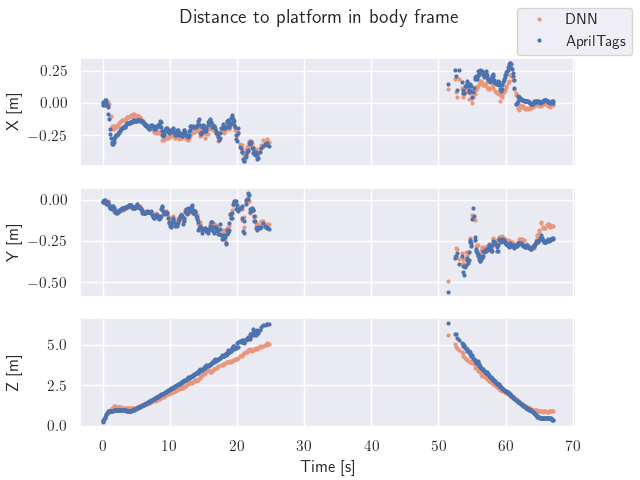

In [11]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["DNN", "AprilTags"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
plt.savefig("figures_mission/full_no_gnss.svg")

# WITHOUT GNSS 

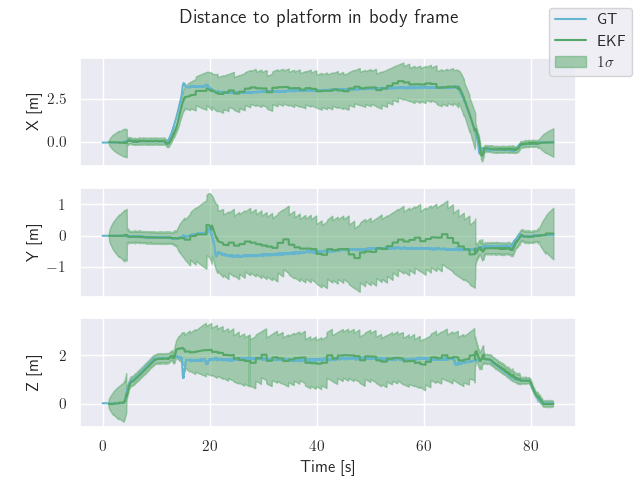

In [29]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])




axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()

In [76]:
df_merged_position = sync_dfs_based_on_time([df_ekf_pose, df_apriltag_pose, df_dnn_pose, df_anafi_height])

df_merged_position = normalize_df_time(df_merged_position)

# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", "covariance_0", "covariance_4", "covariance_8"])

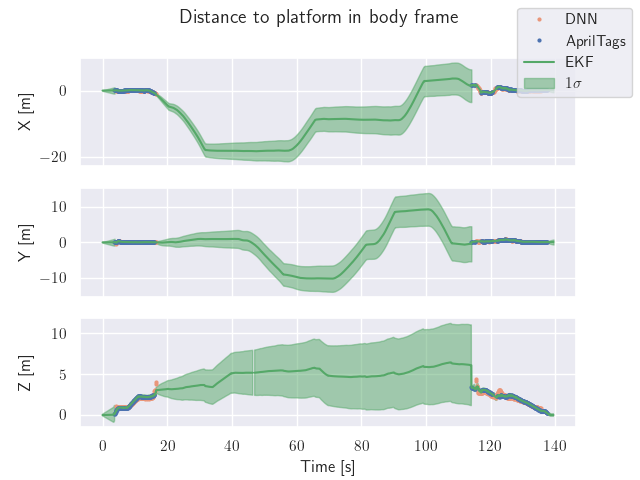

In [77]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])





axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["DNN", "AprilTags", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
plt.savefig("figures_mission/full_no_gnss.svg")